# Cartopyを用いて描画してみる

[全国合成レーダーエコー強度](https://github.com/yellowmeteor/met_python.github.io/blob/master/met_nb/radar_echo.ipynb)ではBasemapを使用して地図上にプロットしました。

しかし，[Basemapの公式ページ](https://matplotlib.org/basemap/)を見てみますと，

*Basemap is deprecated in favor of the Cartopy project. See notes in Cartopy, New Management, and EoL Announcement for more details.*

とあります（2020/05/03現在）。つまり，Cartopyプロジェクトがあるので，Basemapはもう更新しないとのことです。

今はまだBasemapを使用することができますが，matplotlibの更新によっては使用できなくなる可能性があります。

そのため，今回はCartopyの使い方を紹介します。

<br>

## 先駆者の方々の文献

Cartopyについて調査をしてみますと，既にCartopyの使い方についてまとめられている文献を発見しました。

 - [matplotlib：cartopyのTIPS](http://ebcrpa.jamstec.go.jp/~yyousuke/matplotlib/cartopy.html)，山下陽介氏
 - [Cartopyで地理データを可視化する1](http://metpost.hatenablog.com/entry/2015/11/05/180006)，ttmych氏
 
もう私が改めて作画をする必要がなさそうですね…

そこで，私は実際に描画してみて気になった点を述べていきます。

<br>

## Libraryのインストール

condaを使用している方は非常に簡単にインストールできます。

```
$ conda install -c conda-forge cartopy
```

conda以外を使用している方は，公式ページでインストール方法が紹介されていますので，そちらを参照してください。

[Cartopyインストール方法](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing)

今回はCartopyを使用するためのライブラリがあれば十分です。

<br>

In [1]:
# Libraries
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from cartopy.crs import PlateCarree, LambertConformal
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io import shapereader
import numpy as np

今回使用するライブラリは以上です。

今回の描画に使用したCartopyのバージョンは0.17.0でした。

<br>

## 世界の海岸線を描画してみる

まずは非常に簡単な描画として，海岸線の描画をチャレンジしてみます。

C:\Users\haseken\Miniconda3\lib\site-packages\cartopy\mpl\geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
C:\Users\haseken\Miniconda3\lib\site-packages\cartopy\mpl\geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


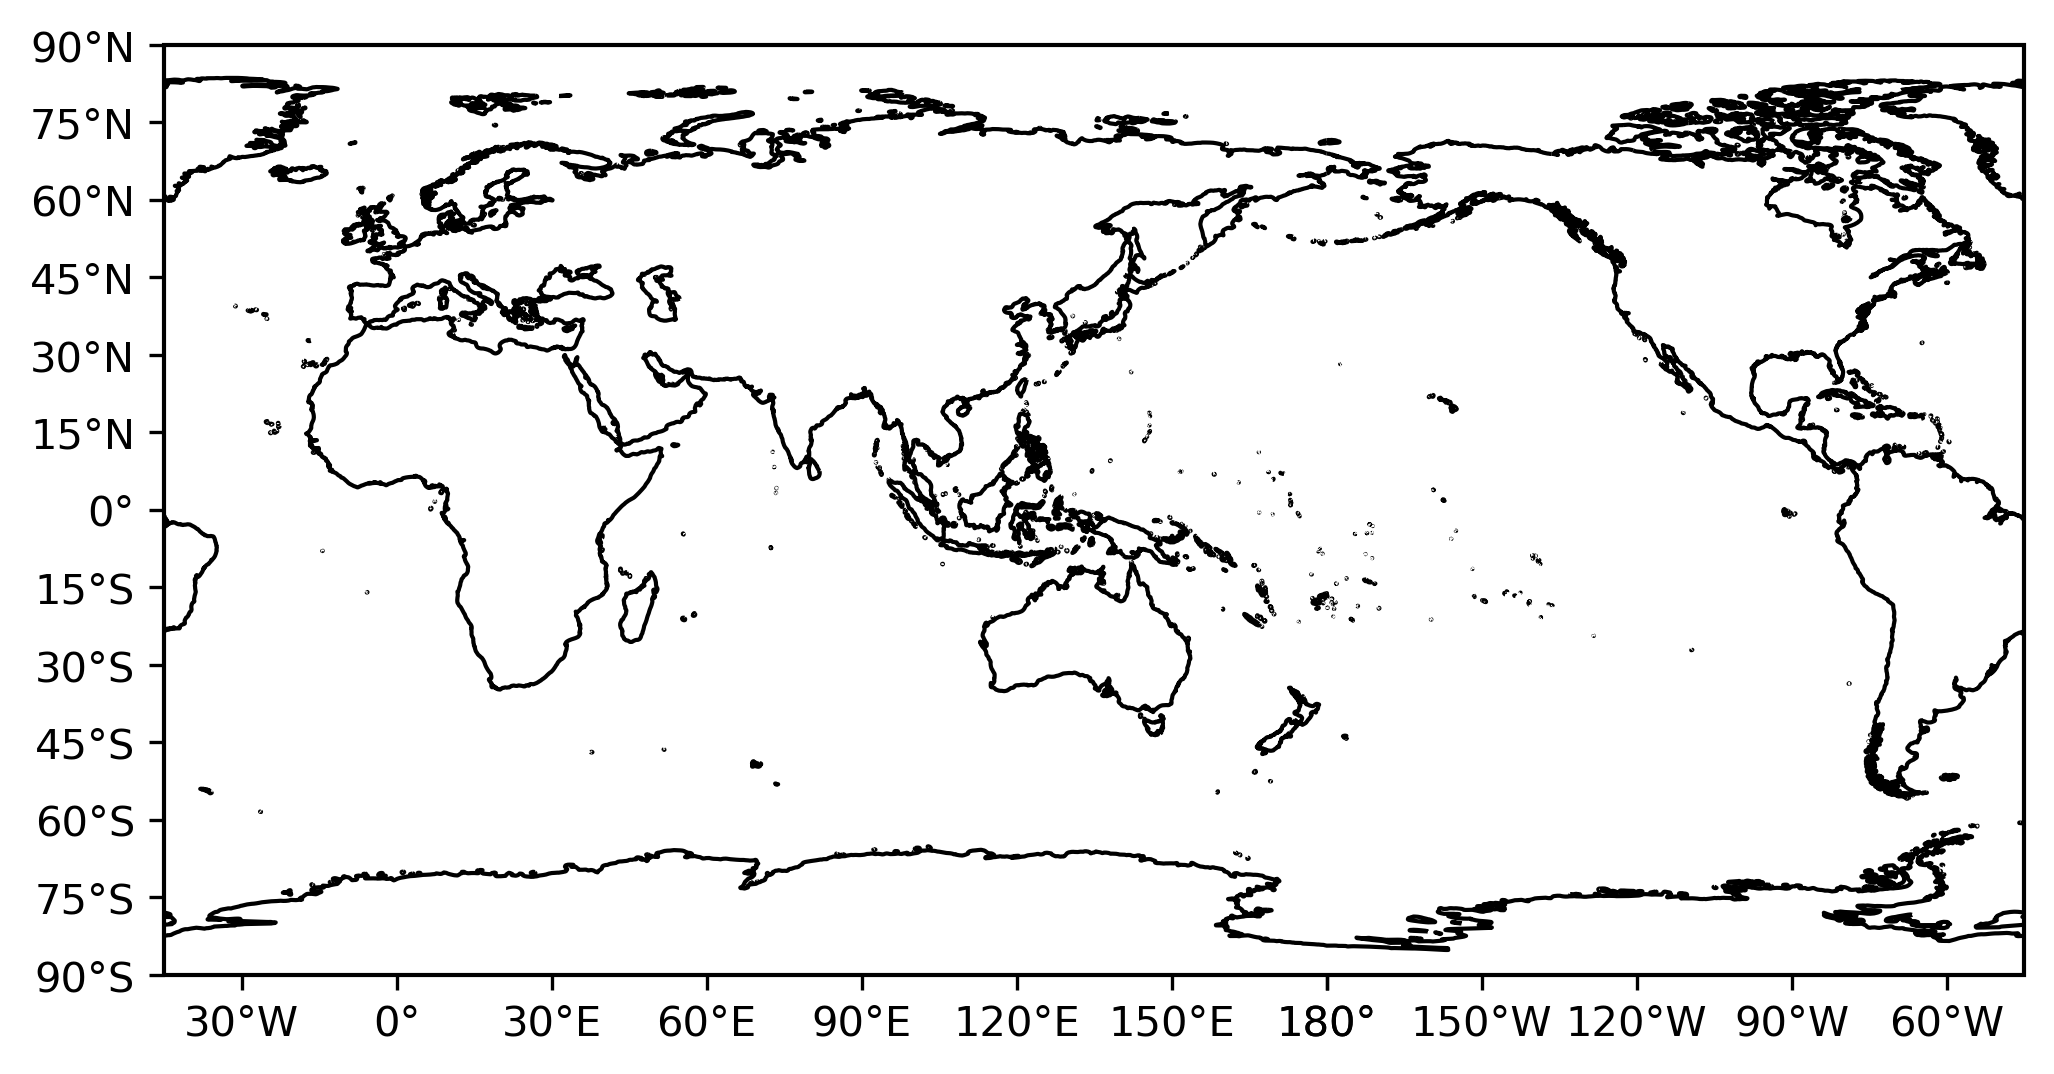

In [2]:
fig = plt.figure(figsize=(8, 6), dpi=300) # dpiの指定はここかsavefigのところ（Cartopyの描画には不要）
ax = fig.add_subplot(1, 1, 1, projection=PlateCarree(central_longitude=135.)) # 地図の形式の指定はここ
ax.coastlines(linewidth=1., resolution="50m") # 海岸線の解像度は110m, 50m, 10mの3種類，初めて使用する際にダウンロードが行われるのでネット環境が必要
ax.set_xticks(np.linspace(-180, 180, 13), crs=PlateCarree()) # crs=PlateCarree()のところでMatplotlibDeprecationWarningが出るが，現状公式でのticksの描き方がこれ
ax.set_yticks(np.linspace(-90, 90, 13), crs=PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter()) # ﾟNなどを描いてくれる
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.show()
plt.close("all")

なんとか描画することができましたね。

ticksを描くところでエラーが出てしまいます。

また，ticksを描く際に，**crs=PlateCarree()**が必要となります。

projectionが変化しているので，それに合わせないといけないわけですね。

<br>

## 地図の上にデータを描画してみる

さて，ここからが本題となります。

Cartopyを使用して気象データの描画をしてみましょう。

今回は2019年10月25日12時の全国合成レーダーエコー強度を描画してみます。

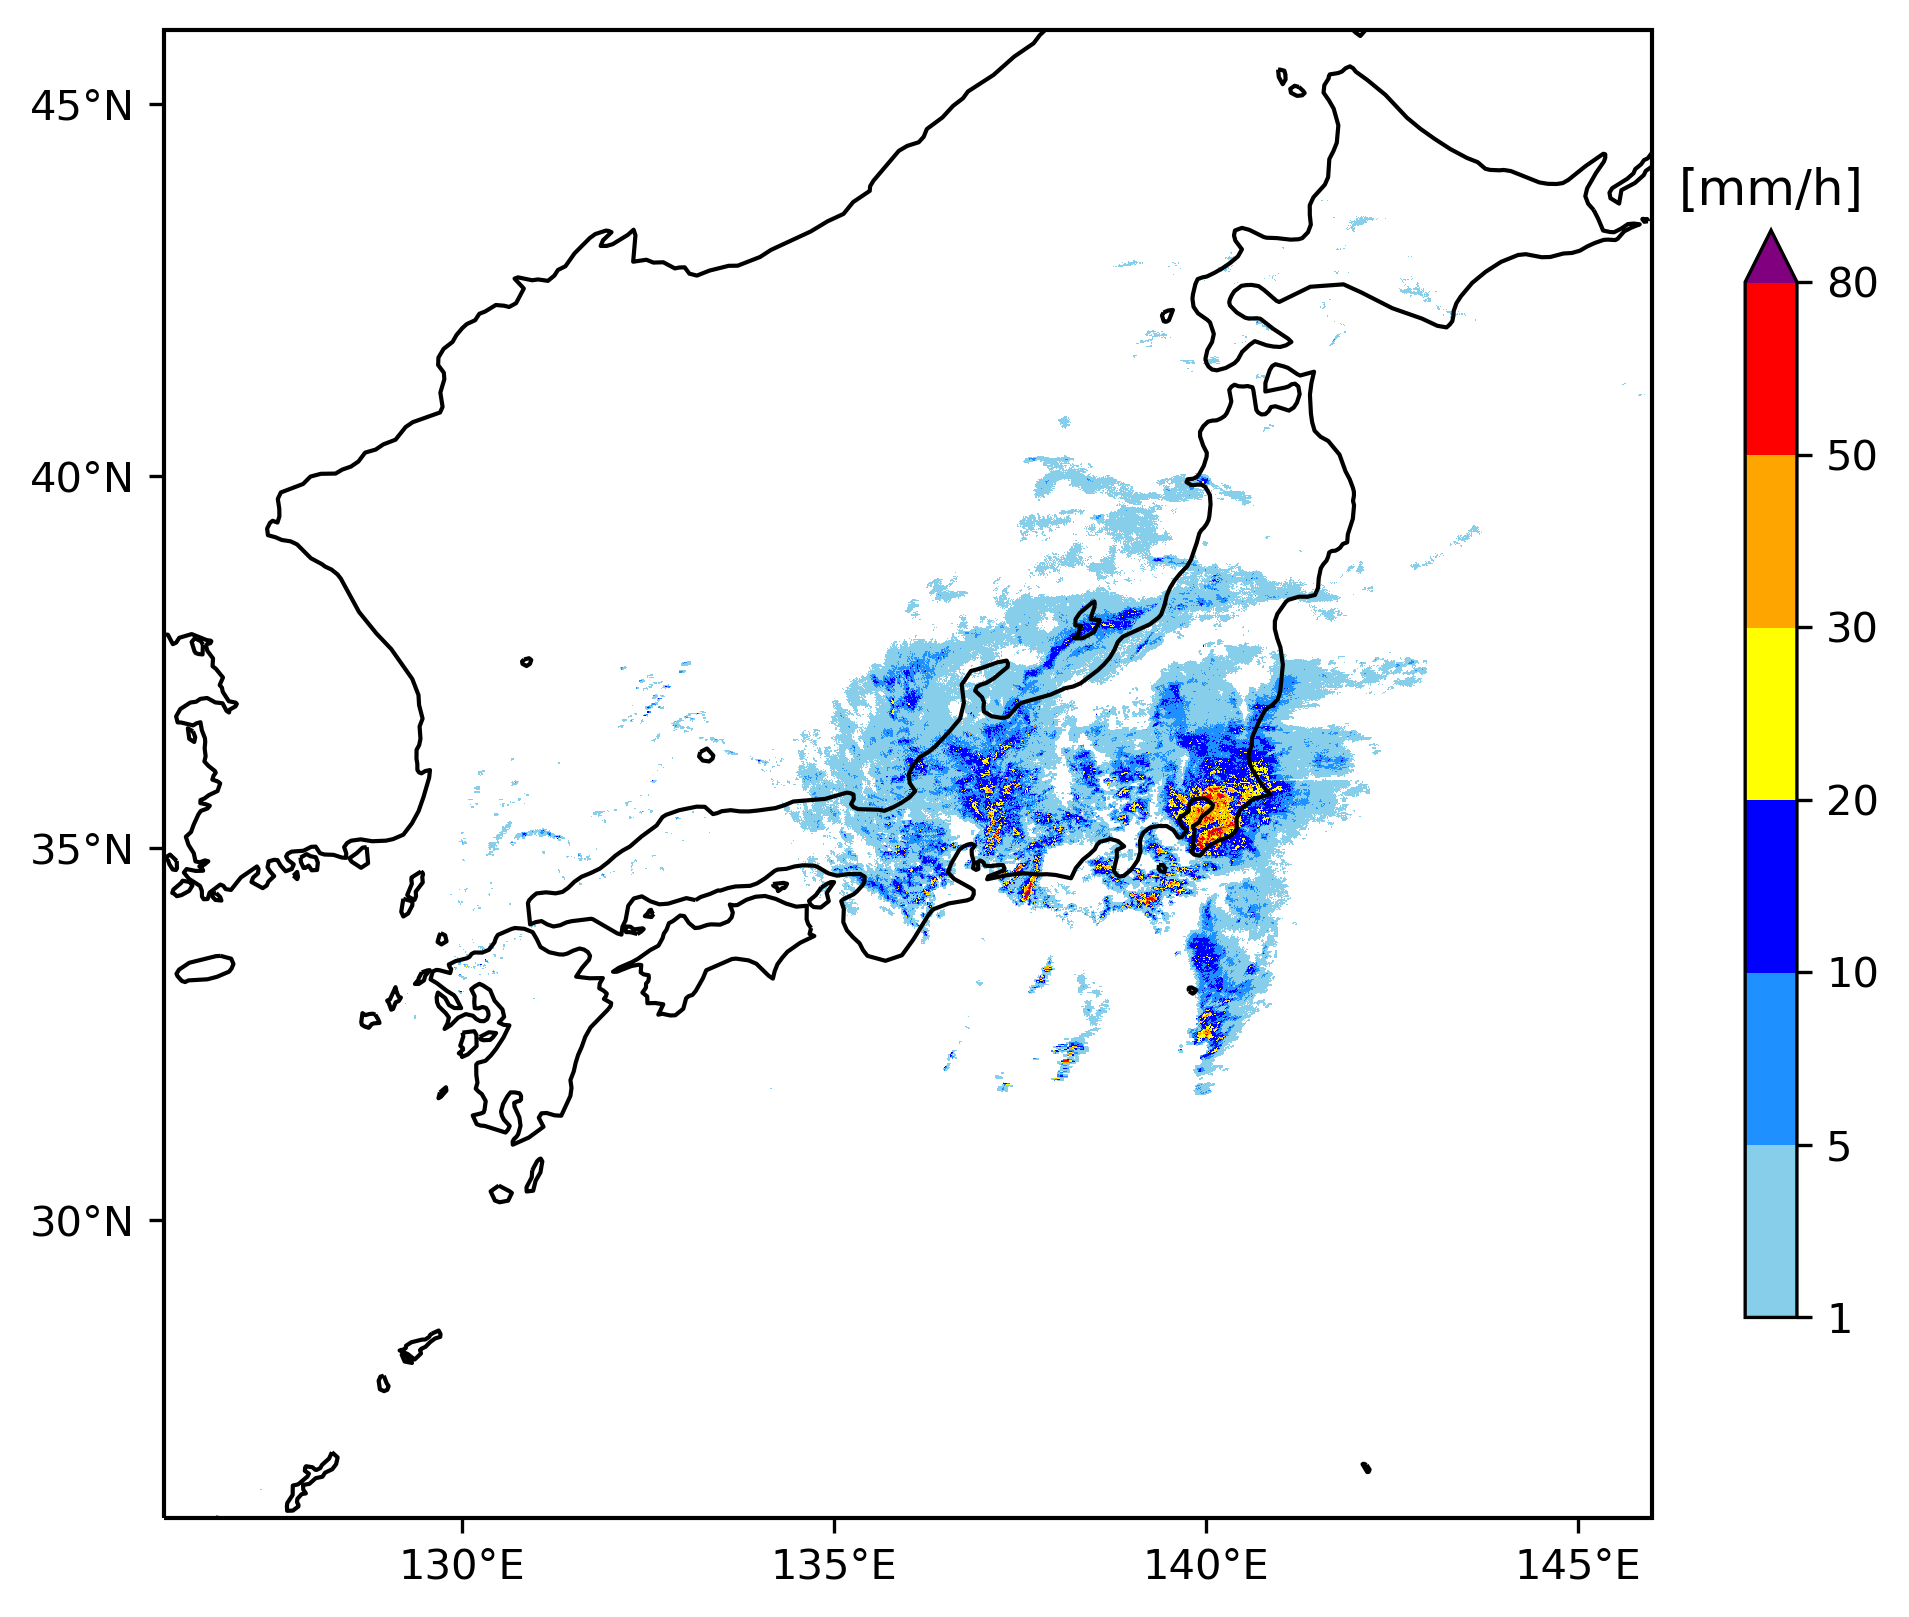

In [3]:
# input
pre = np.load("./20191025_1200.npz")["intensity"]
lon = np.linspace(118., 150., 2561) # 経度方向2560地点 +1 
lat = np.linspace(48., 20., 3361) # 緯度方向3360地点 +1 
pre = np.pad(pre, [[0, 1], [1, 0]], "constant") # 経度方向の東側に1列，緯度方向の北側に1行，データを追加（pcolormeshでは描画されない1行，1列を用意）

# colormap settings
cs = ["skyblue", "dodgerblue", "blue", "yellow", "orange", "red"]
cmap = colors.ListedColormap(cs)
cmap.set_over("purple")
cmap.set_under("white") # 1 mm/h 未満を白色で埋めるために必要
norm = colors.BoundaryNorm([1, 5, 10, 20, 30, 50, 80], ncolors=len(cs))

# plot
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=PlateCarree(central_longitude=136.))
ax.coastlines(resolution="50m")
plot = ax.pcolormesh(lon, lat, pre, cmap=cmap, norm=norm, transform=PlateCarree()) # transform=PlateCarree()がポイント
cbar = fig.colorbar(plot, shrink=0.6, extend="max")
cbar.ax.set_title("[mm/h]")
ax.set_extent([126, 146, 26, 46])
ax.set_xticks(np.linspace(130, 145, 4), crs=PlateCarree())
ax.set_yticks(np.linspace(30, 45, 4), crs=PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.show()
plt.close("all")

Cartopyを使用する上で注意すべき点は，**transform=PlateCarree()**を使用するところです。

これを使用すると，わざわざx座標，y座標の値を他で計算しなくても描きたいところにデータを描画することができます。

また，xlimやylimは，set_extent([xmin, xmax, ymin, ymax])を使用します。

その点以外は通常のmatplotlibの描画法と先程の海岸線の描画法を使用すれば作成することができます。

<br>

今回はpcolormeshを使用して描画をしてみました。

contourfですと内挿処理が行われますので，そのままの値を描画するときにはpcolor系ですね。

しかし，pcolor系には問題点がありまして，4つの格子点に囲まれた部分は，x座標・y座標共に小さい地点のデータを使用して塗りつぶすという設定がデフォルトであるところです。

それなのに，描画する範囲はx座標・y座標の値が存在する場所にしか描画しないので，x座標・y座標いずれかが最も大きい地点のデータは描画されません。

また，pcolor系はcontourfとは色の塗り方の指定方法が異なるので，カラーマップの設定から始めないといけない点が厄介ですね。

<br>

## 他の図法で描画してみる

今まではPlateCarree（正距円筒図法，lonとlatが1:1でx軸とy軸になる図法，matplotlibではcyl）を使用してきました。

通常はPlateCarreeでいいのですが，今回は他の図法を使用してみます。

図法の変化に伴い，描き方が異なってきますので，ご注意下さい。

緯度・経度・エコー強度・カラーマップの設定は先程のものを使用します。

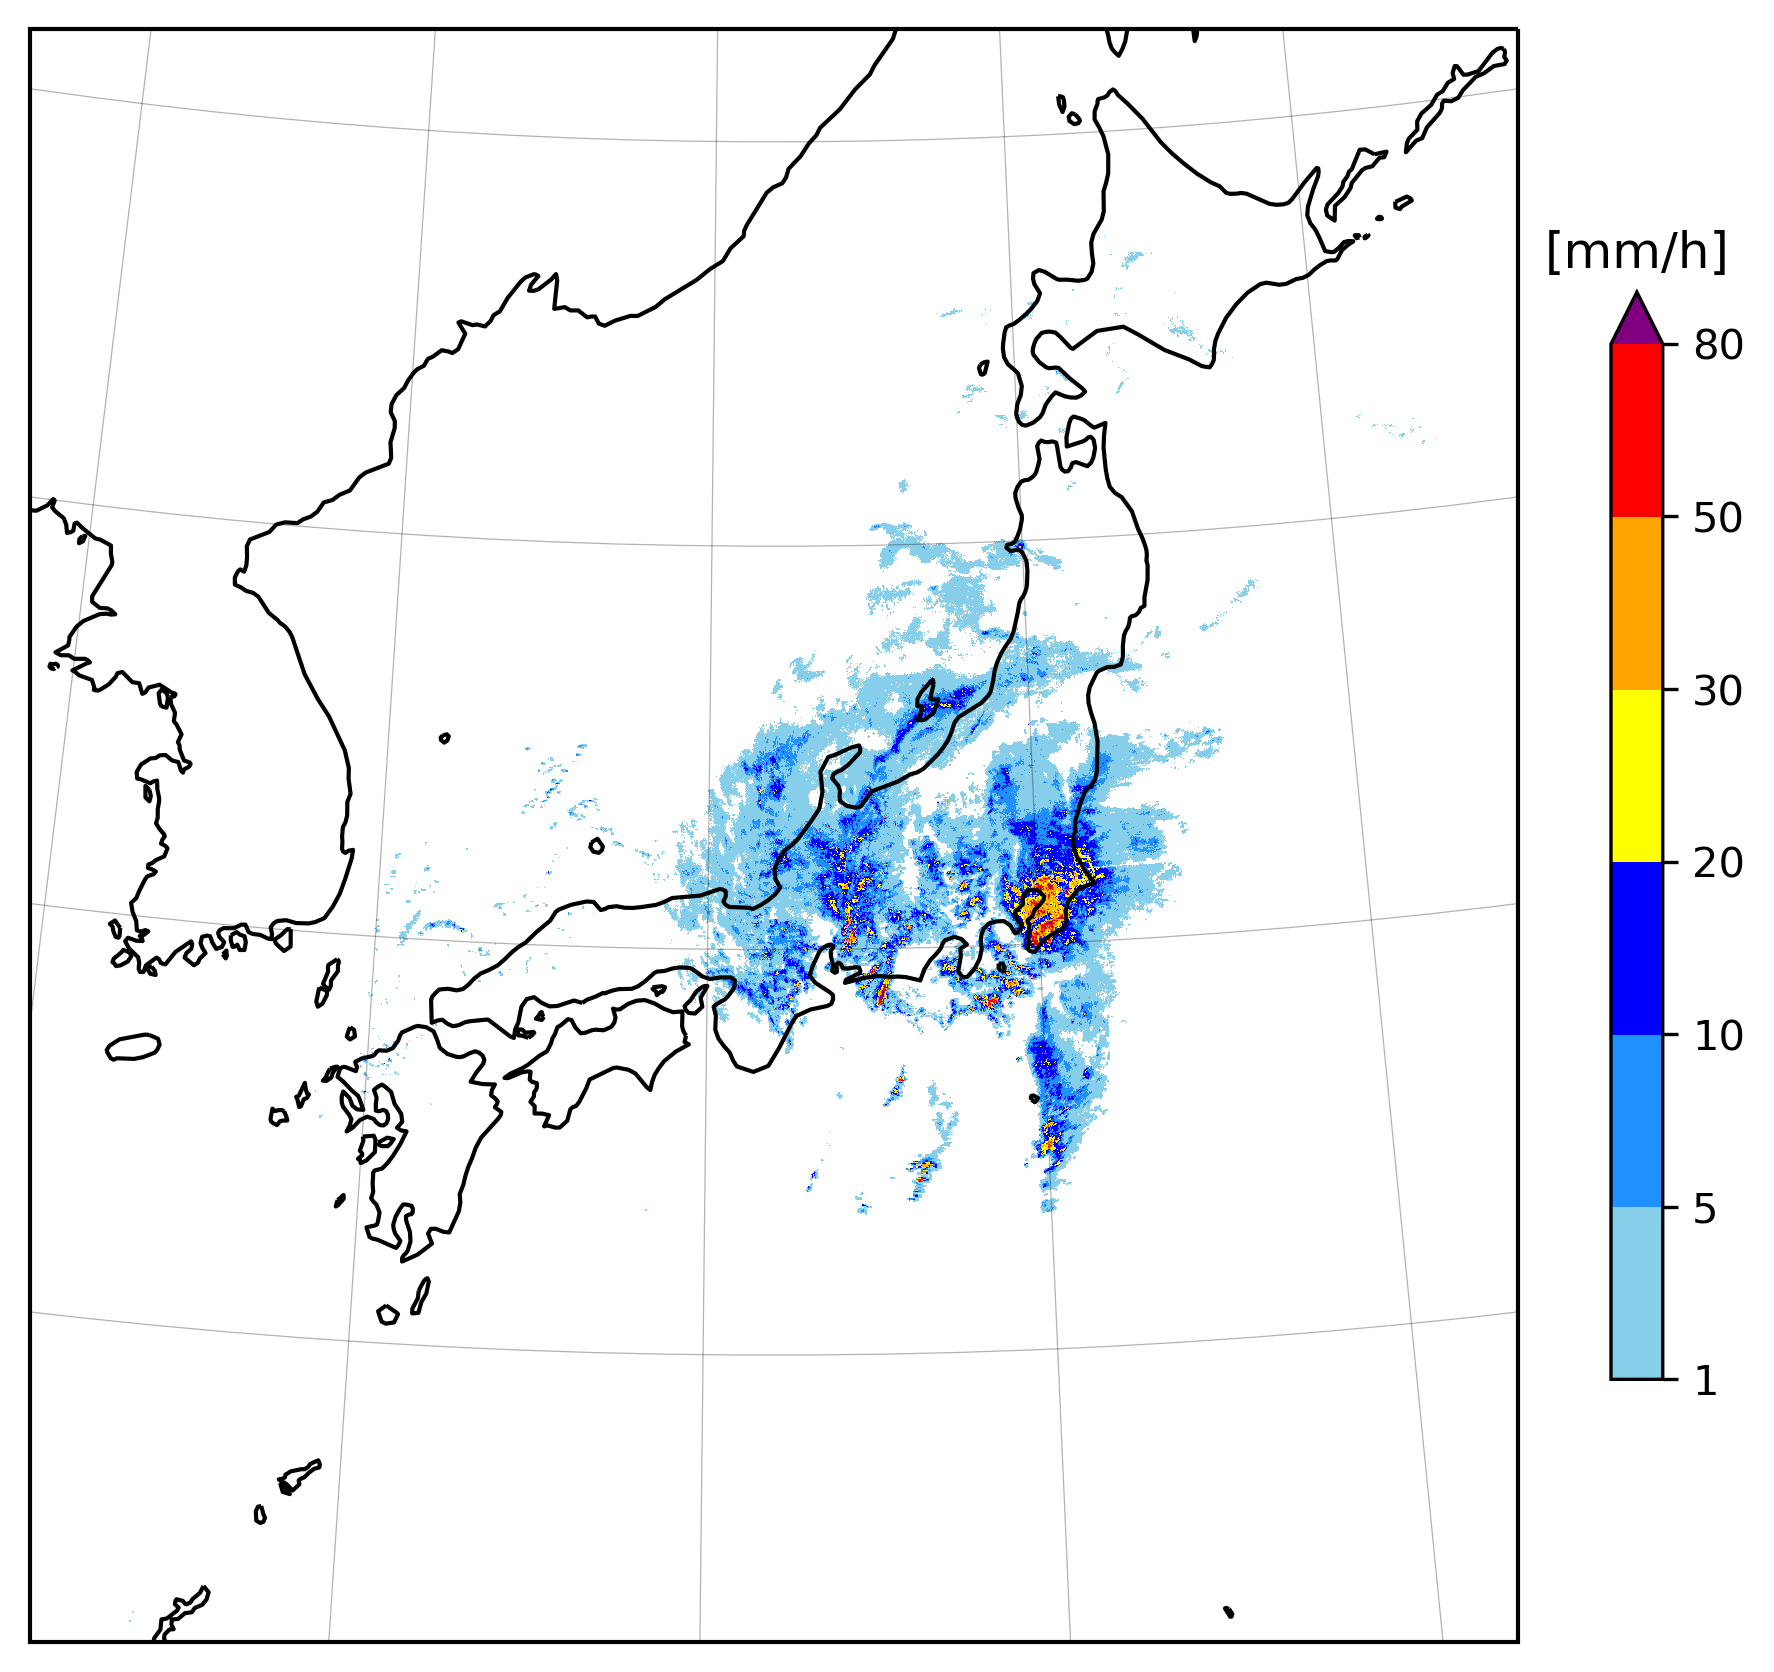

In [4]:
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=LambertConformal(central_longitude=136., central_latitude=36.))
ax.coastlines(resolution="50m")
plot = ax.pcolormesh(lon, lat, pre, cmap=cmap, norm=norm, transform=PlateCarree()) # transform=PlateCarree()がポイント
cbar = fig.colorbar(plot, shrink=0.6, extend="max")
cbar.ax.set_title("[mm/h]")
ax.set_extent([126, 146, 26, 46])
gl = ax.gridlines(crs=PlateCarree(), linewidth=0.3, color="black", alpha=0.3)
gl.xlocator = ticker.FixedLocator(np.linspace(120, 150, 7))
gl.ylocator = ticker.FixedLocator(np.linspace(20, 50, 7))
plt.show()
plt.close("all")

今回はLambert Conformal図法を使用してプロットしてみました。WRFでも使用できる図法ですね。

現在ticksの表示をサポートしているのはPlateCarreeとMercator（メルカトル図法）だけとのことで，代わりにグリッドを描画しました。

エコー強度やグリッドの描画の際にtransformやcrsを指定するのですが，ここにはLambertConformal()ではなく，PlateCarree()を使用します。

これは他の図法を用いたときにも同様です。

<br>

また，Lambert Conformal図法では，中心の経度だけではなく，緯度も指定しました。

図法によって指定するものが異なります。

他に使用できる手法については[公式の図法一覧ページ](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)を見てください。

<br>

## 都道府県境界を描画してみる

なんと，Cartopyでは都道府県境界までもダウンロードして使用できます！

日本地図を拡大してしまうと，海岸線だけではどこを描画しているのかわからなくなるので，都道府県の境界を描きたくなると思います。

今回はその都道府県の境界を加えて，描画してみます。

緯度・経度・エコー強度・カラーマップの設定は先程のものを使用します。

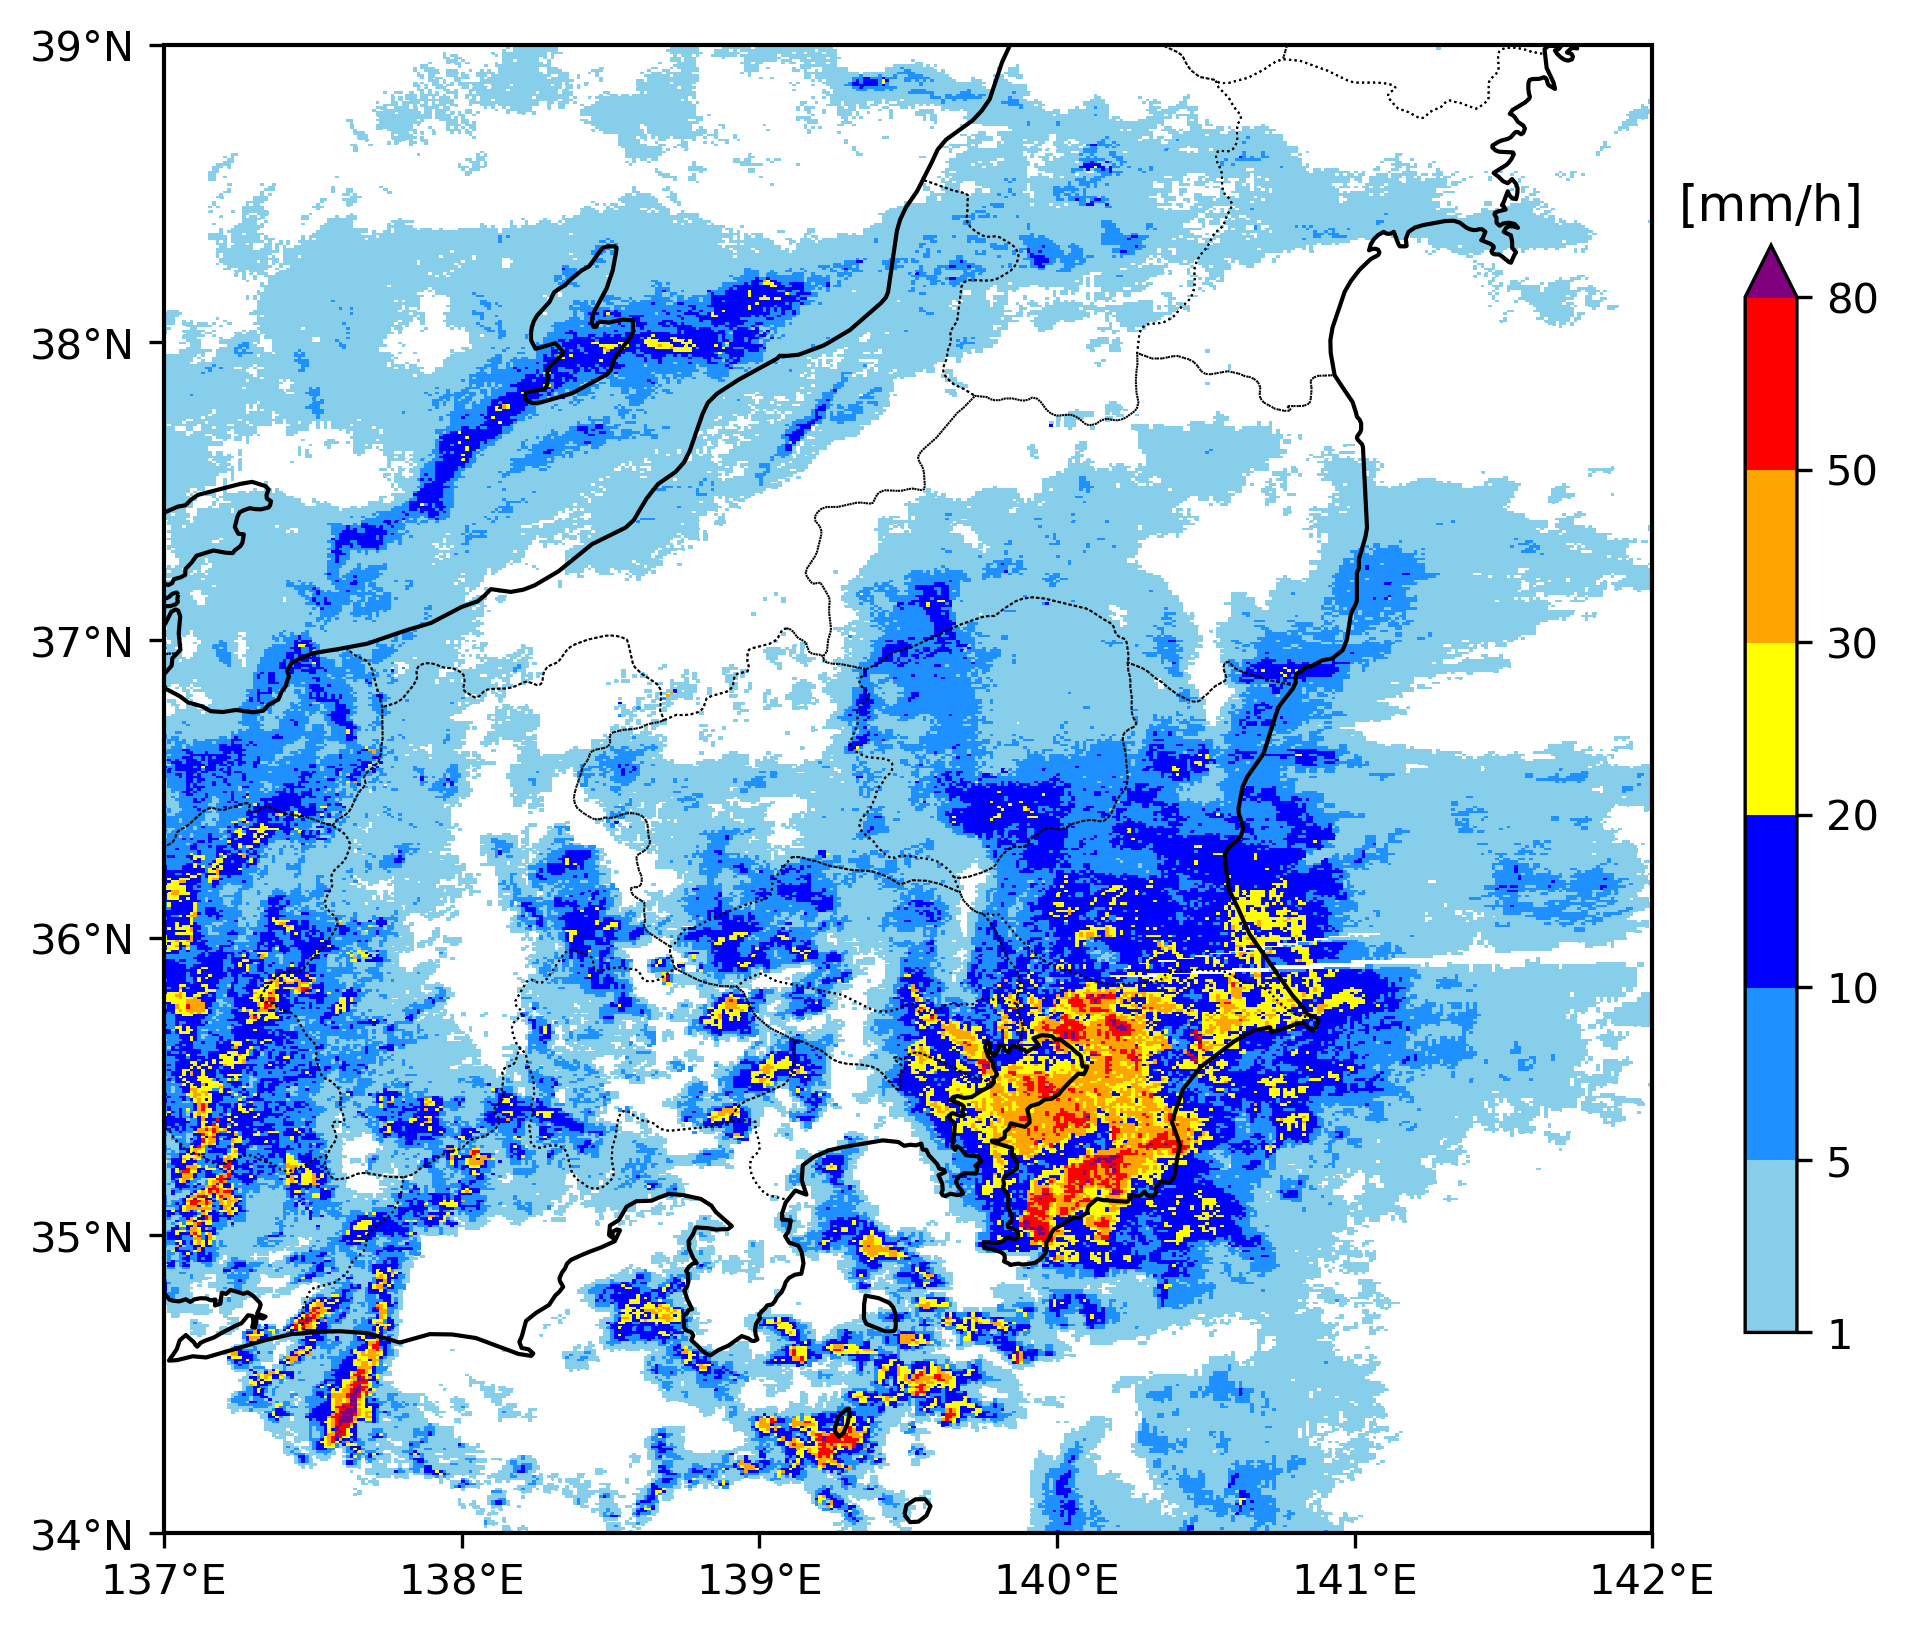

In [5]:
# input
shpfile = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfile).records()
japan_provinces = filter(lambda province: province.attributes['admin'] == 'Japan', provinces) # 日本国内の境界のみを抽出

# plot
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=PlateCarree(central_longitude=136.))
ax.coastlines(resolution="10m")
for province in japan_provinces:
    ax.add_geometries(province.geometry, PlateCarree(), edgecolor='black', facecolor='none', linestyle=':', linewidth=0.5) # 都道府県の境界を1都道府県ずつ描画
plot = ax.pcolormesh(lon, lat, pre, cmap=cmap, norm=norm, transform=PlateCarree()) # transform=PlateCarree()がポイント
cbar = fig.colorbar(plot, shrink=0.6, extend="max")
cbar.ax.set_title("[mm/h]")
ax.set_extent([137, 142, 34, 39])
ax.set_xticks(np.linspace(137, 142, 6), crs=PlateCarree())
ax.set_yticks(np.linspace(34, 39, 6), crs=PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.show()
plt.close("all")

shapeファイルを読み込んで，add_geometriesで描画しています。

使用するshapeファイルの形状とその使い方さえ分かってしまえば，他のところからダウンロードしてきたShapeファイルのデータも描画することができます。

例. [Pythonで世界地図-26(各国の県境・市町村境を表示)](https://qiita.com/ty21ky/items/193e316370a8c7122b3c) ty21ky氏

shapeファイルの使用で描画の幅が広がりそうですね。

<br>

[ホームへ戻る](https://yellowmeteor.github.io/met_python.github.io/)